In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,16)
plt.style.use('bmh')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
import seaborn as sns
from keras.callbacks import *
from sklearn.metrics import *

In [2]:
# Importing Training Set
df = pd.read_csv('C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\GTWYDaily.csv', index_col=0, parse_dates=True)

df

,Electric,Gas,Water,temp,dew_point,pressure,humidity,wind_speed
Datetime,,,,,,,,
2008-05-23,21.259812,4.716729,0.102063,13.193333,9.482083,1013.916667,78.416667,3.830833
2008-05-24,9.742125,4.643917,0.001313,12.617500,8.603750,1013.958333,76.875000,7.959167
2008-05-25,9.466250,4.789521,0.001104,11.202083,9.725417,1014.250000,90.625000,7.675000
2008-05-26,9.720917,4.913646,0.002917,12.089167,8.680417,1014.333333,79.750000,9.237917
2008-05-27,9.453167,4.650792,0.004125,11.814583,10.532500,1011.708333,92.000000,4.222917
...,...,...,...,...,...,...,...,...
2022-02-24,57.230000,90.713354,0.000000,5.173333,1.981667,1008.750000,80.208333,7.111667
2022-02-25,51.441667,92.109000,0.000000,6.274167,2.117083,1024.291667,75.083333,5.198333
2022-02-26,29.384167,3.954271,-0.000417,5.840417,1.968750,1028.250000,76.916667,5.150833


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
values = df.values

# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

In [5]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.107019,0.022507,0.110838,0.591425,0.641306,0.553251,0.539964,0.251043,0.002619
2,0.002619,0.022159,0.001870,0.573909,0.606920,0.553812,0.507105,0.595597,0.000119
3,0.000119,0.022854,0.001645,0.530855,0.650833,0.557735,0.800178,0.571881,0.002427
4,0.002427,0.023446,0.003605,0.557838,0.609921,0.558857,0.568384,0.702323,0.000000
5,0.000000,0.022192,0.004912,0.549486,0.682430,0.523543,0.829485,0.283767,0.119268


In [6]:
newpath = 'C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Metrics'
if not os.path.exists(newpath):
    os.makedirs(newpath)

Epoch 14: early stopping
Good Model RMSE: 25.99 R^2: -20.037 MAE: 22.011 MSE: 675.475
Epoch 12: early stopping
Good Model RMSE: 26.724 R^2: -43.426 MAE: 22.847 MSE: 714.167
Epoch 12: early stopping
Good Model RMSE: 27.23 R^2: -66.936 MAE: 23.518 MSE: 741.458
Good Model RMSE: 15.448 R^2: 43.645 MAE: 12.523 MSE: 238.633
Epoch 43: early stopping
Good Model RMSE: 14.589 R^2: 43.005 MAE: 11.497 MSE: 212.85
Epoch 11: early stopping
Good Model RMSE: 19.219 R^2: -16.155 MAE: 16.149 MSE: 369.364
Epoch 47: early stopping
Good Model RMSE: 14.402 R^2: 21.938 MAE: 11.392 MSE: 207.432
Good Model RMSE: 13.055 R^2: 21.593 MAE: 10.456 MSE: 170.435
Epoch 30: early stopping
Good Model RMSE: 11.352 R^2: 41.145 MAE: 8.994 MSE: 128.867
Epoch 42: early stopping
Good Model RMSE: 10.593 R^2: 46.385 MAE: 8.295 MSE: 112.202
Epoch 27: early stopping
Good Model RMSE: 10.02 R^2: 43.656 MAE: 7.99 MSE: 100.404
Epoch 31: early stopping
Good Model RMSE: 7.56 R^2: 36.176 MAE: 5.991 MSE: 57.159


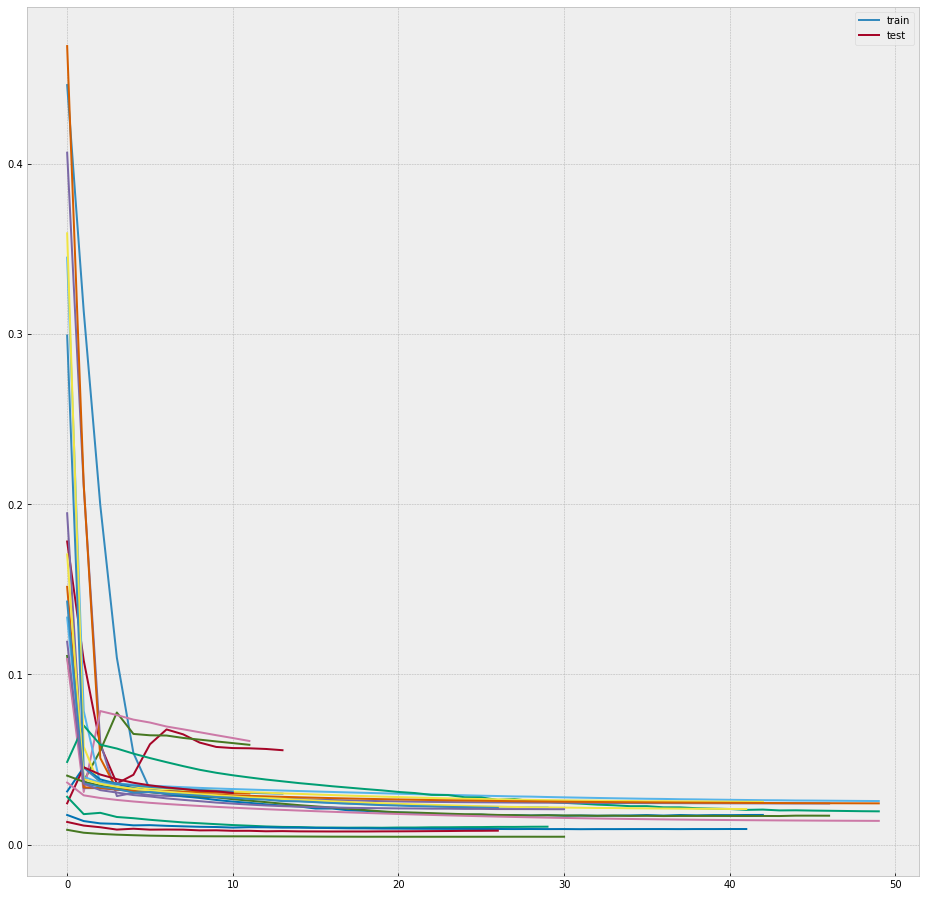

In [7]:
rmse_txt = [0]
mse_txt = [0]
mae_txt = [0]
rs_txt = [0]

folds = []

r_lista = []

# trial = [24, 96, 168]

for i in range(1,13):
    folds.append(i)

    # split into train and test sets
    values = reframed.values
    n_train_hours = 365 * i
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


    # design network
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))

# Compile
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
    loss = 'mean_squared_error'
    model.compile(loss=loss, optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, epochs=50, 
                        validation_data=(test_X, test_y), 
                        verbose=0, shuffle=False, callbacks=[es])

    # plot history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'test'], loc='upper right')
    plt.xticks(rotation='horizontal')
    plt.yticks(rotation='horizontal')
    plt.savefig(newpath + '\\Loss_' + loss + '_Fold_' + str(i) + '.PNG')

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # plt.plot(inv_y.flatten(), marker='.', label='Actual Data')
    # plt.plot(inv_yhat.flatten(), marker='v', color='r', label='Predicted Data')
    # plt.title('Predicted vs Testing', fontweight='bold')
    # plt.legend(shadow=True)
    # plt.xticks(rotation='horizontal')
    # plt.yticks(rotation='horizontal')
    # plt.xlabel('Data points',fontsize=18, ha='center')
    # plt.ylabel('kW',fontsize=18, ha='center')
    # plt.title('Energy Consumption Prediction Validation Data',fontsize=25, ha='center')
    # plt.tick_params(labelsize=18)
    # plt.savefig(newpath+ '\\Validation_' + loss + '_Fold_' + str(i) + '.PNG')


    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    mse = mean_squared_error(inv_y, inv_yhat)
    mae = mean_absolute_error(inv_y, inv_yhat)
    rs = r2_score(inv_y, inv_yhat)*100

    r_lista.append([round(rmse, 3), round(mse, 3), round(mae, 3), round(rs, 3)])

    print('Good Model','RMSE:', round(rmse, 3), 'R^2:', round(rs, 3), 'MAE:', round(mae, 3), 'MSE:', round(mse, 3))

rmse_txt[0] = r_lista[0][0]
mse_txt[0]  = r_lista[0][1]
mae_txt[0]  = r_lista[0][2]
rs_txt[0]   = r_lista[0][3]

for i in range(1,len(r_lista)):
    rmse_txt.append(r_lista[i][0])
    mse_txt.append(r_lista[i][1])
    mae_txt.append(r_lista[i][2])
    rs_txt.append(r_lista[i][3])

rmse_avg = sum(rmse_txt)/len(r_lista)
mse_avg = sum(mse_txt)/len(r_lista)
mae_avg = sum(mae_txt)/len(r_lista)
rs_avg = sum(rs_txt)/len(r_lista)

text = newpath + '.txt'
f= open(text,"w+")
f.write(str(['RMSE AVG','MSE AVG','MAE AVG','R2 AVG']))
f.write('\n')
f.write(str([rmse_avg, mse_avg, mae_avg, rs_avg]))
f.write('\n')
f.write('\n')
f.write(str(['RMSE: ', rmse_txt[:]]))
f.write('\n')
f.write(str(['MSE: ', mse_txt[:]]))
f.write('\n')
f.write(str(['MAE: ', mae_txt[:]]))
f.write('\n')
f.write(str(['R2: ', rs_txt[:]]))
f.write('\n')
f.close()

In [ ]:
# split into train and test sets
# values = reframed.values
# n_train_hours = 365 * 8
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')

In [ ]:
# %%time
# es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)

# # fit network
# history = model.fit(train_X, train_y, epochs=50, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[es])

In [ ]:
# # plot history
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [ ]:
# from sklearn.metrics import *

# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]

# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(test_y, yhat))
# mse = mean_squared_error(test_y, yhat)
# mae = mean_absolute_error(test_y, yhat)
# r2 = r2_score(test_y, yhat)


# # rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# # rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# # mse = mean_squared_error(inv_y, inv_yhat)
# # mae = mean_absolute_error(inv_y, inv_yhat)
# # r2 = r2_score(inv_y, inv_yhat)

# print('Test RMSE: %.3f' % rmse)
# print('Test MSE: %.3f' % mse)
# print('Test MAE: %.3f' % mae)
# print('Test R2: %.3f' % r2)

In [ ]:
# plt.plot(inv_y.flatten(), marker='.', label='Actual Data')
# plt.plot(inv_yhat.flatten(), marker='v', color='r', label='Predicted Data')
# plt.title('Predicted vs Testing', fontweight='bold')
# plt.legend(shadow=True);